# CosmoFlow Benchmark Scaling Analysis

In [1]:
import os
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

In [4]:
def load_config(result_dir):
    config_file = os.path.join(result_dir, 'config.pkl')
    with open(config_file, 'rb') as f:
        return pickle.load(f)

def load_result(result_dir):
    history_file = os.path.join(result_dir, 'history.csv')
    return pd.read_csv(history_file)

def compute_mean_time(r):
    return r[r.epoch>0].time.mean()

def get_num_samples(config, ranks):
    dconf = config['data']
    n = dconf['n_train'] + dconf['n_valid']
    if not dconf['shard']:
        n *= ranks
    return n

def get_scaling_results(path_pattern, ranks):
    """
    Loops over ranks with specified file path pattern and computes scaling metrics.
    Returns results in a dataframe.
    """
    configs, results = [], []
    for r in ranks:
        result_dir = path_pattern % r
        configs.append(load_config(result_dir))
        results.append(load_result(result_dir).assign(ranks=r))
    samples = np.array([get_num_samples(c,r) for (c,r) in zip(configs, ranks)])    
    times = np.array([compute_mean_time(r) for r in results])
    throughputs = samples / times
    ideal = ranks * throughputs[0]
    eff = throughputs / ideal
    return pd.DataFrame(dict(ranks=ranks, samples=samples,
                             times=times, throughputs=throughputs,
                             ideal=ideal, eff=eff))

In [5]:
ls $SCRATCH/cosmoflow-benchmark/

cosmoflow-19-06-11/       cosmoflow-test/           scaling-dummy-n128/
cosmoflow-19-06-12/       cosmoflow-v2-2019-10-22/  scaling-dummy-n16/
cosmoflow-19-06-13/       cosmoflow-v2-2019-10-24/  scaling-dummy-n2/
cosmoflow-19-06-17/       data/                     scaling-dummy-n256/
cosmoflow-19-06-19/       scaling-cgpu-dummy-n1/    scaling-dummy-n32/
cosmoflow-19-06-22-1gpu/  scaling-cgpu-dummy-n16/   scaling-dummy-n4/
cosmoflow-19-06-22-test/  scaling-cgpu-dummy-n2/    scaling-dummy-n512/
cosmoflow-19-06-24/       scaling-cgpu-dummy-n32/   scaling-dummy-n64/
cosmoflow-19-06-25/       scaling-cgpu-dummy-n4/    scaling-dummy-n8/
cosmoflow-19-06-25-cpu/   scaling-cgpu-dummy-n64/   scaling-n1/
cosmoflow-19-07-13-cpu/   scaling-cgpu-dummy-n8/    scaling-n1024/
cosmoflow-19-08-17-cpu/   scaling-cgpu-n1/          scaling-n128/
cosmoflow-19-08-17-gpu/   scaling-cgpu-n16/         scaling-n16/
cosmoflow-19-08-30-gpu/   scaling-cgpu-n2/          scaling-n2/
cosmoflow-19-09-09-sgd/   scaling-c

## Cori GPU scaling

In [6]:
results_cgpu = get_scaling_results(
    os.path.expandvars('$SCRATCH/cosmoflow-benchmark/scaling-cgpu-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64]))

results_cgpu_dummy = get_scaling_results(
    os.path.expandvars('$SCRATCH/cosmoflow-benchmark/scaling-cgpu-dummy-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64]))

In [7]:
# Summary table
results_cgpu.merge(results_cgpu_dummy, on='ranks', suffixes=(None,'_dummy'))

,ranks,samples,times,throughputs,ideal,eff,samples_dummy,times_dummy,throughputs_dummy,ideal_dummy,eff_dummy
0,1,512,12.893975,39.708467,39.708467,1.000000,512,11.679684,43.836801,43.836801,1.000000
1,2,1024,12.833653,79.790221,79.416934,1.004700,1024,12.799187,80.005081,87.673602,0.912533
2,4,2048,15.058182,136.005793,158.833869,0.856277,2048,12.773162,160.336178,175.347205,0.914393
3,8,4096,18.533700,221.002820,317.667738,0.695704,4096,13.916620,294.324333,350.694410,0.839262
4,16,8192,19.009904,430.933267,635.335475,0.678277,8192,15.088690,542.923196,701.388820,0.774069
5,32,16384,19.279959,849.794357,1270.670951,0.668776,16384,15.837898,1034.480685,1402.777639,0.737452
6,64,32768,22.272266,1471.246792,2541.341901,0.578925,32768,16.143928,2029.741404,2805.555279,0.723472


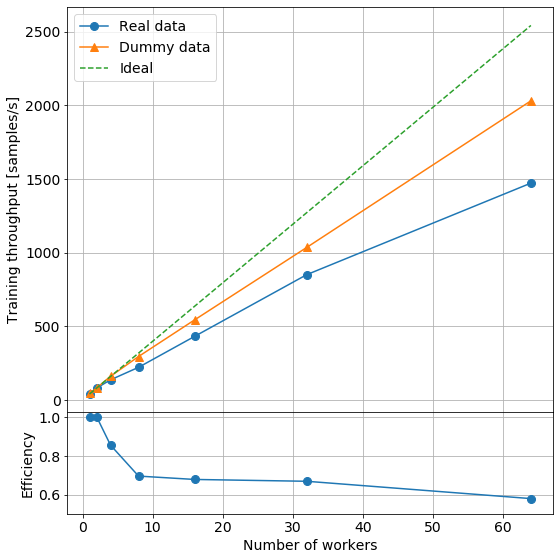

In [8]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8,8),
                               gridspec_kw=dict(height_ratios=[.8, .2], hspace=0))

ax0.plot(results_cgpu.ranks, results_cgpu.throughputs, 'o-', ms=8, label='Real data')
ax0.plot(results_cgpu_dummy.ranks, results_cgpu_dummy.throughputs, '^-', ms=8, label='Dummy data')
ax0.plot(results_cgpu.ranks, results_cgpu.ideal, '--', label='Ideal')
ax0.set_ylabel('Training throughput [samples/s]')
ax0.legend(loc=0)
ax0.grid()

# Scaling efficiency
ax1.plot(results_cgpu.ranks, results_cgpu.eff, 'o-', ms=8)
ax1.set_xlabel('Number of workers')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(bottom=0.5)
ax1.grid()

plt.tight_layout()

## Cori CPU scaling

In [9]:
results = get_scaling_results(
    os.path.expandvars('$SCRATCH/cosmoflow-benchmark/scaling-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]))

results_dummy = get_scaling_results(
    os.path.expandvars('$SCRATCH/cosmoflow-benchmark/scaling-dummy-n%i'),
    ranks=np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]))

In [10]:
# Summary table
results.merge(results_dummy, on='ranks', suffixes=(None,'_dummy'))

,ranks,samples,times,throughputs,ideal,eff,samples_dummy,times_dummy,throughputs_dummy,ideal_dummy,eff_dummy
0,1,64,17.317688,3.695643,3.695643,1.000000,64,17.458997,3.665732,3.665732,1.000000
1,2,128,18.528065,6.908439,7.391287,0.934673,128,18.280915,7.001838,7.331463,0.955040
2,4,256,18.764791,13.642571,14.782574,0.922882,256,18.746286,13.656038,14.662927,0.931331
3,8,512,18.910925,27.074297,29.565148,0.915750,512,18.912969,27.071371,29.325853,0.923123
4,16,1024,19.091434,53.636619,59.130295,0.907092,1024,19.109365,53.586290,58.651707,0.913636
5,32,2048,19.181881,106.767423,118.260591,0.902815,2048,19.299099,106.118943,117.303414,0.904653
6,64,4096,19.419858,210.918124,236.521181,0.891752,4096,19.439863,210.701077,234.606828,0.898103
7,128,8192,19.644668,417.008818,473.042362,0.881546,8192,19.615880,417.620819,469.213656,0.890044
8,256,16384,20.561300,796.836774,946.084725,0.842247,16384,20.052720,817.046250,938.427312,0.870655
9,512,32768,21.172881,1547.640124,1892.169450,0.817918,32768,20.588671,1591.554910,1876.854623,0.847991


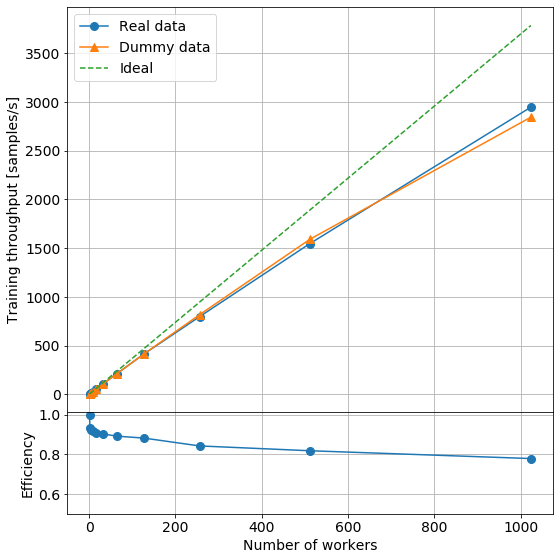

In [11]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8,8),
                               gridspec_kw=dict(height_ratios=[.8, .2], hspace=0))

ax0.plot(results.ranks, results.throughputs, 'o-', ms=8, label='Real data')
ax0.plot(results_dummy.ranks, results_dummy.throughputs, '^-', ms=8, label='Dummy data')
ax0.plot(results.ranks, results.ideal, '--', label='Ideal')
ax0.set_ylabel('Training throughput [samples/s]')
ax0.legend(loc=0)
ax0.grid()

# Scaling efficiency
ax1.plot(results.ranks, results.eff, 'o-', ms=8)
ax1.set_xlabel('Number of workers')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(bottom=0.5)
ax1.grid()

plt.tight_layout()

## Discussion

The scaling performance looks pretty decent, achieving about 80% of ideal throughput speedup at 1k CPU nodes.

The data pipeline seems well tuned for CPU. We are not even using the Burst Buffer, but the scaling is about as good as with dummy data.
However, it seems there may be some room for improvement there on the GPU system.